<center><h1><u> ΕΡΓΑΣΙΑ 1 - ΤΕΧΝΙΚΕΣ ΕΞΟΡΥΞΗΣ ΔΕΔΟΜΕΝΩΝ </u></h1></center>
<center><h2> ΜΠΑΚΑΛΙΑΝΟΣ ΜΙΧΑΗΛ 1115201700269 </h2></center>
<center><h2> ΤΡΙΓΚΑΣ ΕΥΣΤΑΘΙΟΣ 1115201700167 </h2></center>

In [181]:
import datetime as dt
import numpy as np
import pandas as pd
import os
import glob
import csv
import matplotlib.pyplot as plt
import io
from operator import itemgetter 

import folium
from folium import plugins
from PIL import Image

import nltk #ασκ 3
import string #datapreparation
from string import punctuation #datapreparation
from nltk.corpus import stopwords #datapreparation
from nltk.stem import WordNetLemmatizer #datapreparation
from nltk.stem import PorterStemmer #datapreparation
from textblob import Word  #datapreparation

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import linear_kernel
from nltk.collocations import BigramCollocationFinder
from nltk import word_tokenize 


### Σε αυτό εδώ το κομμάτι , ξεκινάμε να φτιάχνουμε το αρχείο <u> train.csv </u>

In [182]:

february=pd.read_csv('../data/febrouary/listings.csv',low_memory=False)
march=pd.read_csv('../data/march/listings.csv',low_memory=False)
april=pd.read_csv('../data/april/listings.csv',low_memory=False)


#### Προσθέτουμε σε κάθε αρχείο μία παραπάνω στήλη , με όνομα month και σε κάθε αρχείο με βαση τον μήνα που αναφέρεται , προσθέτουμε στην στήλη αυτή τον αντίστοιχο μήνα.

In [183]:
february['month'] = 'february'
march['month'] = 'march'
april['month'] = 'april'

In [184]:
def keep_cols(DataFrame, keep_these): #η συνάρτηση αυτη παρίνει όρισμα ένα Dataframe 
    drop_these = list(set(list(DataFrame)) - set(keep_these)) # και τις στήλες που θέλουμε να κρατήσουμε
    return DataFrame.drop(drop_these, axis = 1) # και επιστρέφει το αντίστοιχο Dataframe με τις συγκεκριμένες στήλες

new_april = april.pipe(keep_cols, ['id','zipcode','month','transit','bedrooms','beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood', 'name' ,'latitude' ,'longitude' ,'last_review', 'instant_bookable' ,'host_since', 'host_response_rate' ,'host_identity_verified' ,'host_has_profile_pic' ,'first_review' ,'description' ,'city' ,'cancellation_policy' ,'bed_type', 'bathrooms' ,'accommodates' ,'amenities', 'room_type' ,'property_type', 'price', 'availability_365','minimum_nights'])
new_march = march.pipe(keep_cols, ['id','zipcode','month','transit','bedrooms','beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood', 'name' ,'latitude' ,'longitude' ,'last_review', 'instant_bookable' ,'host_since', 'host_response_rate' ,'host_identity_verified' ,'host_has_profile_pic' ,'first_review' ,'description' ,'city' ,'cancellation_policy' ,'bed_type', 'bathrooms' ,'accommodates' ,'amenities', 'room_type' ,'property_type', 'price', 'availability_365','minimum_nights'])
new_february = february.pipe(keep_cols, ['id','zipcode','month','transit','bedrooms','beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood', 'name' ,'latitude' ,'longitude' ,'last_review', 'instant_bookable' ,'host_since', 'host_response_rate' ,'host_identity_verified' ,'host_has_profile_pic' ,'first_review' ,'description' ,'city' ,'cancellation_policy' ,'bed_type', 'bathrooms' ,'accommodates' ,'amenities', 'room_type' ,'property_type', 'price', 'availability_365','minimum_nights'])



#### Σε αυτό το κομμάτι , ενώνουμε τα 3 αρχέια , τα αρχεία για κάθε μήνα , σε ένα , στο τελικό train

In [185]:
matrix = [new_april,new_march,new_february]
dfall = pd.concat(matrix)
dfall = dfall.sort_values(by='id')
dfall.to_csv('train.csv',index=False)
train = pd.read_csv('train.csv')


### Το αρχείο train είναι έτοιμο , τώρα μπορούμε να ασχοληθούμε εκτελόντας τα διάφορα ερωτήματα πάνω σε αυτό.

 <center><h2> ΑΣΚΗΣΗ 1 </h2></center>

#### --------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.1 
##### Βρίσκουμε το άθροισμα για κάθε είδος room type και στη συνέχεια ταξινομόυμε βάσει αυτού και φτιάχνουμε το γράφημα.
##### Επιλέξαμε το γράφημα να αναπαρασταθεί με τη μορφή πίτας 


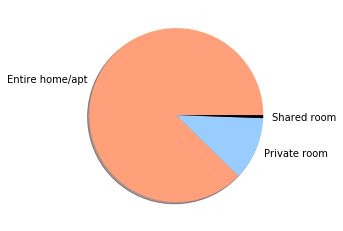

In [186]:

q1 = train.pipe(keep_cols,['id','room_type'])
q1 = q1.drop_duplicates() 
q1 = q1.drop(columns = ['id']) 
q1['room_type_sum'] = 1
q1 = q1.groupby(['room_type']).sum()
q1 = q1.sort_values(['room_type_sum'], ascending=False)
q1 = q1.reset_index()
q1 = q1.dropna()
colors = ['#ffa07a','#99CCFF','#000000']
plt.pie(q1['room_type_sum'],labels = q1.room_type,colors=colors,shadow = True,)
plt.show()

#### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.2 
##### Βρίσκουμε τον Μ.Ο. των τιμών με βάση τον μήνα,εφόσον πρώτα έχουμε επεξεργαστεί το αρχείο , για να είναι σε μορφή κατανοητή απο το σύστημα (αφαιρούμε διάφορους χαρακτήρες απο το πεδίο 'price')
##### Επιλέξαμε το γράφημα να έχει αυτή τη μορφή και επίσης το ταξινομήσαμε με βάση τον μήνα και όχι αλφαβητικά όπως έβγαινε by default.

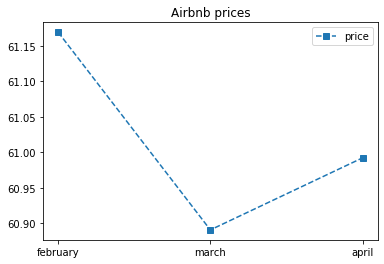

In [187]:
q2 = train.pipe(keep_cols,['month','price'])
q2['price'] = q2['price'].str.lstrip('$')
q2['price'] = pd.to_numeric(q2['price'],errors='coerce')
q2 = q2.groupby(['month']).mean()
q2 = q2.reset_index()
q2 = q2.dropna()

months = ['january','february','march','april','may','june','july','august','september','octomber','november','december']
mapping = {month: i for i,month in enumerate(months)}
key = q2['month'].map(mapping)
q2 = q2.iloc[key.argsort()]
plt.title('Airbnb prices')
plt.plot(q2.month,q2.price,'s--',label='price')
plt.legend()
plt.show()

#### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.3
##### Βρίσκουμε το άθροισμα των κριτικών για κάθε γειτονιά και στη συνέχεια ταξινομούμε με βάση τις γειτονιές
##### Επιλέξαμε ένα γράφημα στο οποίο φαίνονται οι γειτονιές στον άξονα y και τα αθροίσματα στον άξονα x.

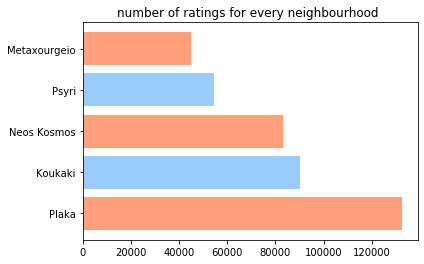

In [188]:
q3 = train.pipe(keep_cols,['neighbourhood','number_of_reviews'])
q3 = q3.groupby('neighbourhood').sum().sort_values(['number_of_reviews'], ascending=False).head()
q3 = q3.dropna()
q3 = q3.reset_index()

plt.title('number of ratings for every neighbourhood ')
colors = ['#ffa07a','#99CCFF']
plt.barh(q3.neighbourhood,q3.number_of_reviews,color = colors)
plt.show()

#### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.4
#### Παρόμοια διαδικασία με το ερώτημα 1.1

In [221]:
q4 = train.pipe(keep_cols,['id','neighbourhood'])
q4 = q4.dropna()
q4 = q4.drop_duplicates()
q4 = q4.drop(columns = ['id'])
q4['neighbourhood_sum']= 1
q4 = q4.groupby(['neighbourhood']).sum()
q4 = q4.sort_values(['neighbourhood_sum'], ascending=False)

print("Η γειτονιά με τις περισσότερες καταχωρήσεις ακινήτων φαινεται παρακάτω " )
q4.head(1)


Η γειτονιά με τις περισσότερες καταχωρήσεις ακινήτων φαινεται παρακάτω 


neighbourhood_sum
neighbourhood                   
Plaka                       1216

##### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.5
#### Σε αυτό το ερώημα βρίσκουμε για κάθε γειτονιά , τις καταχωρήσεις για κάθε μήνα.

In [222]:
q5 = train.pipe(keep_cols,['id','neighbourhood','month'])
q5 = q5.dropna()
q5 = q5.drop(columns = ['id'])
q5['neighbourhood_sum']=1
q5 = q5.groupby(['neighbourhood' , 'month']).sum()
q5


neighbourhood_sum
neighbourhood  month                      
Agios Loukas   april                    71
               february                 68
               march                    70
Agios Nikolaos april                   209
               february                196
...                                    ...
Thiseio        february                314
               march                    94
Votanikos      april                    59
               february                 50
               march                    54

[96 rows x 1 columns]

##### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.6

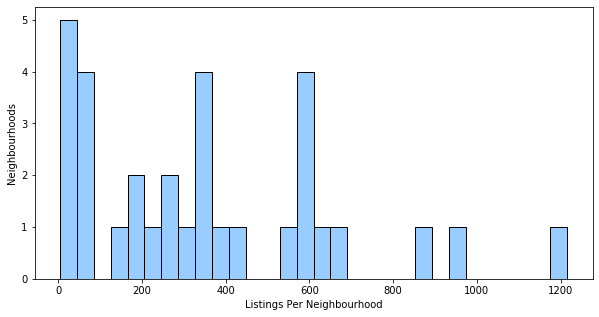

In [223]:
q6=train.pipe(keep_cols,['neighbourhood','id'])
q6 = q6.drop_duplicates()
q6 = q6.dropna()
q6 = q6.drop(columns = ['id'])
q6['sum'] = 1
q6 = q6.groupby(['neighbourhood']).sum()

plt.figure(figsize=(10,5))
plt.hist(q6['sum'],bins=30,edgecolor='black',color = '#99CCFF')
plt.xlabel('Listings Per Neighbourhood')
plt.ylabel('Neighbourhoods')
plt.show()

##### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.7
#### Σε αυτό το ερώημα βρίσκουμε για κάθε γειτονιά , τους συχνοτερους τυπους δωματιων

In [224]:
q7 = train.pipe(keep_cols,['id','room_type','neighbourhood'])
q7 = q7.dropna()
q7 = q7.drop_duplicates()
q7 = q7.drop(columns = ['id'])
q7['room_type_sum']=1
q7 = q7.groupby(['neighbourhood','room_type'] ).sum()
q7

room_type_sum
neighbourhood  room_type                     
Agios Loukas   Entire home/apt             69
               Private room                11
               Shared room                  1
Agios Nikolaos Entire home/apt            193
               Private room                33
...                                       ...
Thiseio        Entire home/apt            308
               Private room                26
               Shared room                  2
Votanikos      Entire home/apt             55
               Private room                 6

[85 rows x 1 columns]

##### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.8
#### Σε αυτό το ερώημα βρίσκουμε τον ακριβοτερο τύπο δωματίου

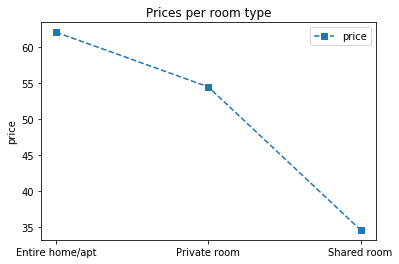

In [225]:

# We compute the average price of each room type.
# We are finding the values and then return the room type with the highest average value. 
q8 = train.pipe(keep_cols,['id','room_type','price'])
q8 = q8.dropna()
q8 = q8.drop(columns = ['id'])
q8['price'] = q8['price'].str.lstrip('$')
q8['price'] = pd.to_numeric(q8['price'],errors='coerce')
q8 = q8.groupby(['room_type' ]).mean()
q8 = q8.reset_index()
plt.title('Prices per room type')
plt.plot(q8.room_type,q8.price,'s--',label='price')
plt.ylabel('price')
plt.legend()
plt.show()


##### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.9
#### Σε αυτό το ερώτημα φτιάχνουμε τον χάρτη για τον μήνα Μάρτιο και επιλέξαμε το popup να περιέχει τις πληροφορίες από το bed_type καθώς και θέσαμε στις συντεταγμένες του χάρτη το κέντρο της Αθήνας ώστε να υπάρχει μια ισορροπία στις αποστάσεις αλλά και να είναι πιο αισθητικά ωραίο.

In [226]:
map_data = march.pipe(keep_cols,['latitude' ,'longitude' , 'bed_type']) #Keeping the long,lat as needed.
# print(map_data.mean())
map = folium.Map(location=[37.983810, 23.727539], zoom_start=13) #We set the map location as the coordinates of Athens

locations = map_data[['latitude', 'longitude']]
locationlist = locations.values.tolist() #Transform the array into list of longtitude and latitude 

#FIRST TYPE OF MAP PREVIEW.WITHOUT NUMBERS 

# for point in range(0, len(locationlist)): #This is the real line for the code but 
                                            #beacause the number of points (apx 10.000) the system is running very slow.
for point in range(0, 300): # We use a normal number of 300 spots to preview the map
    folium.Marker(locationlist[point], popup=map_data['bed_type'][point]).add_to(map) #and add the point into the map
map


#### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.10
#### Σε αυτό το ερώτημα φτιάχνουμε τα wordclouds για τις στήλες που ζητούνται.
#### Έχουμε προσθέσει μια εικόνα δική μας "cloud.jpg" η οποία είναι το σχήμα ενός συννέφου και την έχουμε βάλει στα wordclouds ώστε να είναι πιο ωραίο και πιο κοντά στην έννοια του cloud.Ανάλογα με το WordCloud που αναφερόμαστε έχουν προστεθεί σχόλια για να περιγράψουν το τι κάνουμε σε κάποιες γραμμές που χρειάζονται εξήγηση.

<Figure size 432x288 with 0 Axes>

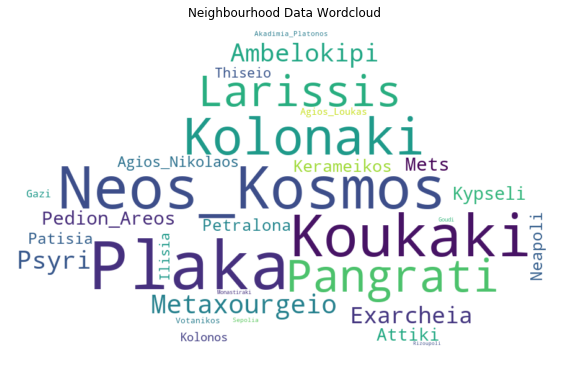

In [227]:

#In this section we are making the wordcloud for neighbourhood

from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
neighbourhood_data = train.pipe(keep_cols,['neighbourhood'])

neighbourhood_data = neighbourhood_data.dropna()
neighbourhood_data = neighbourhood_data.replace(' ', '_', regex=True)#with this command,we are replacing all the spaces
                                                                      # , e.x. the word "Neos Kosmos" seems as "Neos_Kosmos"
neighbourhood_string = " ".join(neighbourhood_data['neighbourhood'])


cloud_mask = np.array(Image.open( "cloud.jpg")) #the wordcloud shape

neighbourhood_wordcloud = WordCloud(mask=cloud_mask , stopwords=STOPWORDS,collocations=False,
                          background_color='white', 
                          max_words=30
                         ).generate(neighbourhood_string)

plt.clf()
plt.figure (figsize =(10,10)) #change the dimensions of the figure,make it bigger
plt.imshow(neighbourhood_wordcloud,interpolation="bilinear") #we want the wordcloud to follow the border of the image .

plt.title('Neighbourhood Data Wordcloud ')
plt.axis('off')
plt.show()


<Figure size 432x288 with 0 Axes>

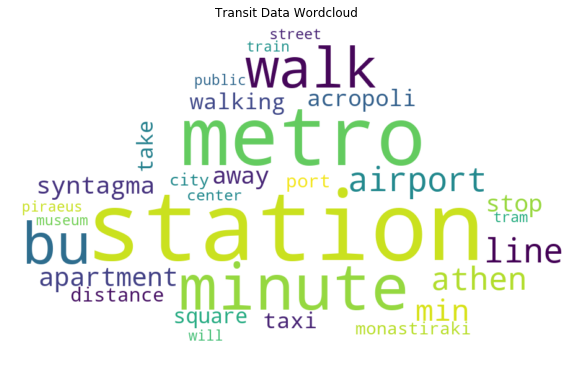

In [228]:
#In this section we are making the wordcloud for transit.
transit_data = train.pipe(keep_cols,['transit'])
transit_data = transit_data.dropna()
# if you try to uncomment these lines,its not useful because we dont need to replace the spaces with undescore here.
# print(transit_data)
# transit_data = transit_data.replace(' ', '_', regex=True) #with this command,we are replacing all the spaces
                                                          # , e.x. the word "green line" seems as "green_line"
transit_string = " ".join(transit_data['transit'].str.lower())


transit_wordcloud = WordCloud(mask=cloud_mask,stopwords=STOPWORDS,collocations=False,
                          background_color='white', 
                          max_words=30
                         ).generate(transit_string)

plt.clf()
plt.figure (figsize =(10,10)) 
plt.imshow(transit_wordcloud,interpolation="bilinear")

plt.title('Transit Data Wordcloud')
plt.axis('off')
plt.show()

<Figure size 432x288 with 0 Axes>

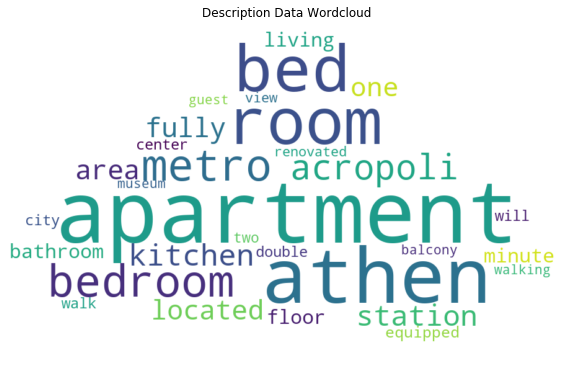

In [229]:
#In this section we are making the wordcloud for description.
description_data = train.pipe(keep_cols,['description'])
description_data = description_data.dropna()
description_string = " ".join(description_data['description'].str.lower())

description_wordcloud = WordCloud(mask=cloud_mask,stopwords=STOPWORDS,collocations=False,
                          background_color='white', 
                      max_words=30
                         ).generate(description_string)

plt.clf()
plt.figure (figsize =(10,10))
plt.imshow(description_wordcloud,interpolation="bilinear")

plt.title('Description Data Wordcloud')
plt.axis('off')
plt.show()


In [230]:
# In this section we are preparing the review data instead of making the wordcloud of the comments.

#First we are fetching the data for each month from the local data directory
february_reviews=pd.read_csv('../data/febrouary/reviews.csv',low_memory=False)
march_reviews=pd.read_csv('../data/march/reviews.csv',low_memory=False)
april_reviews=pd.read_csv('../data/april/reviews.csv',low_memory=False)

#Then we make one dataframe only with the comments column from each month
february_reviews = february_reviews.pipe(keep_cols, ['comments'])
march_reviews = march_reviews.pipe(keep_cols, ['comments'])
april_reviews = april_reviews.pipe(keep_cols, ['comments'])

#And concatenate the 3 fetched datasets to one 
matrix = [february_reviews,march_reviews,april_reviews]
dfall = pd.concat(matrix)
dfall.to_csv('allreviews.csv',index=False)

reviews_data = pd.read_csv('allreviews.csv')
reviews_data = reviews_data.dropna()   


<Figure size 432x288 with 0 Axes>

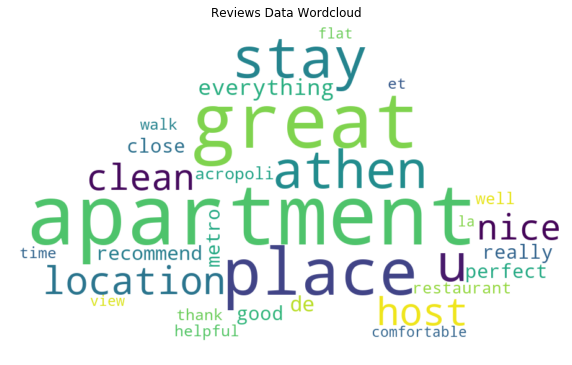

In [231]:
# In this section we are making the wordcloud.
 
reviews_string = " ".join(reviews_data['comments'].str.lower()) #Note: We dont need to remove whitespaces because w
                                                                  #we are only looking for words. 

reviews_wordcloud = WordCloud(mask=cloud_mask,stopwords=STOPWORDS,collocations=False,
                          background_color='white', 
                      max_words=30
                         ).generate(reviews_string)

plt.clf()
plt.figure (figsize =(10,10))
plt.imshow(reviews_wordcloud,interpolation="bilinear")

plt.title('Reviews Data Wordcloud')
plt.axis('off')
plt.show()



#### -------------------------------------------------------------------------------------------------------------------------------------------------------
#### Ερώτημα 1.12
#### Σε αυτό το ερώτημα επιλέξαμε να φτιάξουμε έναν ακόμα χάρτη ο οποίος ομαδοποιεί τα ακίνητα που βρίσκονται σε μικρή απόσταση μεταξύ τους και μας δείχει ανα περιοχή πόσα ακίνητα υπάρχουν καθώς επίσης και να βρούμε την τιμή του πιο ακριβού ακινήτου στα δεδομένα μας .

In [232]:
#THIS AN ***EXTRA*** IMPLEMENTATION OF MAP , WITHIN THE NUMBER OF POINTS 

from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(map)
#adding marker and popup of city and crime-name
for point in range(0, 300): # We use a normal number of 300 spots to preview the map
    folium.Marker(locationlist[point], popup=map_data['bed_type'][point]).add_to(marker_cluster)
    folium.LayerControl().add_to(map)
map

<Figure size 432x288 with 0 Axes>

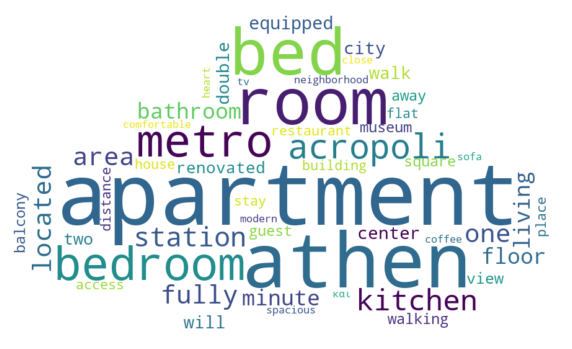

In [233]:
#IN THIS SECTION WE ARE TRYING TO SOLVE 3RD EXERCISE

rec_file = train.pipe(keep_cols,['id','name' ,'description'])
rec_file = rec_file.dropna()

description_wordcloud = WordCloud(mask=cloud_mask,collocations=False,
                          background_color='white' ,
                      max_words=50 
                         ).generate(description_string)

plt.clf()
plt.figure (figsize =(10,10))

plt.imshow(description_wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()



In [234]:
q12 = train.pipe(keep_cols,['id','price'])
q12 = q12.drop_duplicates() 
q12 = q12.drop(columns = ['id'])
q12 = q12.dropna()
q12 = q12.max()
print("The price of the most expensive AirBnB in the list is " + q12.max() )

The price of the most expensive AirBnB in the list is $994.00


 <center><h2> ΑΣΚΗΣΗ 3 </h2></center>

### Άσκηση 3.1 
#### Η άσκηση αυτή ουσιαστικά αποτελείται απο κάποια συγκερκιμένα στάδια.
#### Αρχικά φτιάχνουμε το αρχείο που ζητείται , και έχει τις 3 στήλες "id" , "name" , "description" 

In [235]:
#IN THIS SECTION WE ARE TRYING TO SOLVE 3RD EXERCISE
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

rec_file = april.pipe(keep_cols,['id','name' ,'description'])
rec_file = rec_file.dropna()
# rec_file['new'] = rec_file['name'] +" " + rec_file['description']
# rec_file['new']
rec_file['new'] = rec_file[['name', 'description']].apply(lambda x: ' '.join(x), axis=1)
# rec_file['new'].head()
print(rec_file['new'])
rec_file2 = rec_file['new']


0       96m2, 3BR, 2BA, Metro, WI-FI etc... Athens Fur...
1       75m2, 2-br, metro, wi-fi, cable TV Athens Furn...
2       50m2, Metro, WI-FI, cableTV, more Athens Furni...
3       Studio, metro, cable tv, wi-fi, etc The Studio...
4       47m2, close to metro,cable TV,wi-fi AQA No2 is...
                              ...                        
9656    Lysicrates Monument - Athens 33 "Athens 33" is...
9657    Bright and Stylish Exarchia apartment Newly re...
9658    Athens21 Athens 21 is centrally located right ...
9659    Tower of Winds "Athens 33" is a newly renovate...
9660    Beautiful and modern Pagkrati Apartment Beauti...
Name: new, Length: 9552, dtype: object


#### Στη συνέχεια , σε αυτό το κομμάτι κάνουμε το Data Preparation , όπως επιλέξαμε. Λεπτομέρειες για την διαδικασία αυτή θα δείτε στα σχόλια.

In [236]:
# DATA PREPARATION FOR 3.1
# import nltk
# import string
# from string import punctuation
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
stop = stopwords.words('english')



rec_file['new'] = rec_file['new'].apply(lambda x: x.lower()) #Making all the dataframe in lowercase
 
rec_file['new'] = rec_file['new'].apply(lambda x:" ".join([word for word in x.split() if word not in (stop)])) 
                                                                                    #Here we are removing the stopwords
                                                                                    # from the whole dataframe
rec_file['new'] = rec_file['new'].str.replace('-','')
rec_file['new'] = rec_file['new'].str.replace('[^\w\s]',' ') # Here we are replacing all the content punctuation
                                                            #  with whitespaces
    
rec_file['new'] = rec_file['new'].str.replace("\\d", "") # Here we are replacing all the digits with whitespaces
rec_file['new'] = rec_file['new'].mask(rec_file['new'].map(len) == 1, ' ') # Here we are removing the words with lengh =1 
# rec_file['new'] = rec_file['new'].mask(rec_file['new'].map(len) == 2, ' ') # Here we are removing the words with lengh =1 


# from nltk.stem import PorterStemmer
st = PorterStemmer()
rec_file['new'] = rec_file['new'].apply(lambda x: " ".join([st.stem(word) for word in x.split()])) #Stemming

# from textblob import Word

rec_file['new'] = rec_file['new'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) #Lemmatizing
rec_file['new']

0       m br ba metro wifi etc athen furnish apart no ...
1       m br metro wifi cabl tv athen furnish apart no...
2       m metro wifi cabletv athen furnish apart no be...
3       studio metro cabl tv wifi etc studio excel loc...
4       m close metro cabl tv wifi aqa no bedroom apar...
                              ...                        
9656    lysicr monument athen athen newli renov build ...
9657    bright stylish exarchia apart newli renov two ...
9658    athen athen central locat right next monastira...
9659    tower wind athen newli renov build novemb comp...
9660    beauti modern pagkrati apart beauti modern pag...
Name: new, Length: 9552, dtype: object

In [237]:
corpus = rec_file['new']

In [238]:
# from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, ngram_range = (1,2) , max_features=1000,
stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(corpus)

tfidf_array = tfidf.toarray()
tfidf_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [239]:
#3.3
# from sklearn.metrics.pairwise import linear_kernel

item_id = 10595
num = 5
rec_file['id'].head()
row = rec_file.loc[rec_file['id'] == item_id].index[0]
cosine_similarities = linear_kernel(tfidf[row:row+1], tfidf).flatten()
cosine_similarities
related_docs_indices = cosine_similarities.argsort()[:-(num+2):-1]
related_docs_indices = np.delete(related_docs_indices,0)
#print(related_docs_indices)
print("Recommending ",num,"listings similar to  Studio" )
for x in related_docs_indices:
    print("Recommending: ",rec_file['name'][x])
    print("Description: ",rec_file['description'][x])
    print("score:(",cosine_similarities[x],")")
    print("---------------------------------------------------------------------------")


Recommending  5 listings similar to  Studio
Recommending:  75m2, 2-br, metro, wi-fi, cable TV
Description:  Athens Furnished Apartment No4 is 2-bedroom apartment (75 square meters)  -excellent located  -close to metro station,  -lovely,  -very clean  with all the facilities that you will need, nice balcony, excellent Wi-Fi, cable tv, fully air conditioned… Athens Furnished Apartment No4 is an excellent located, close to metro, lovely, very clean 2-bedroom apartment (75 square meters) with all the facilities that you will need and nice balcony. Fully equipped kitchen with everything you need to prepare your lunch/dinner. Living room to relax and enjoy a movie or a sport event. Big dinner table. Clean nice bathroom. For more than 4 people there is a camp bed. Apartment No4 has everything you will need. -Telephone line for incoming calls or to call us if you need something. -Free fast Wi-Fi from the best internet provider in Greece. You do not share the connection with other people. -32” 

In [240]:
# from nltk.collocations import BigramCollocationFinder
bigram_measures = nltk.collocations.BigramAssocMeasures()

text = ''
for x in corpus:
     print(x)
print(text)
#finder = BigramCollocationFinder.from_words(word_tokenize(text))
#finder.nbest(bigram_measures.pmi, 5)

m br ba metro wifi etc athen furnish apart no bedroom apart bathroom excel locat close metro station love veri clean facil need nice balconi excel wifi cabl tv fulli air condit athen furnish apart no excel locat close metro love clean bedroom apart bathroom facil need balconi nd floor worri elev build fulli equip kitchen everyth need prepar lunch dinner live room relax enjoy movi sport event clean nice bathroom peopl sofa bed apart no everyth need st bedroom doubl bed nd bedroom singl bed rd bedroom singl bed telephon line incom call call u need someth free fast wifi best internet provid greec share con
m br metro wifi cabl tv athen furnish apart no bedroom apart squar meter excel locat close metro station love veri clean facil need nice balconi excel wifi cabl tv fulli air condit athen furnish apart no excel locat close metro love clean bedroom apart squar meter facil need nice balconi fulli equip kitchen everyth need prepar lunch dinner live room relax enjoy movi sport event big dinn

voda penthous place love m penthous appart great terrac quiet bedroom close metro m m m take acropoli within stop airport pireu port easili reach athen railway station m nation archaeolog museum within walk distanc big groceri store street m far apart street safe polic station front entranc build penthous two separ room quiet bedroom small balconi live room access terrac loung decor interior design order assur space ergonom two unit last floor open balconi get fresh airflow thru penthous bedroom comfort bed laptop tabl enabl use laptop bed handmad sofa bed avail live room c
vintag wonderland place close nightlif public transport citi centr you ll love place light kitchen balconi everyth say place good coupl solo adventur busi travel famili recent renov decor apart heart kyps th floor five stori apart build built earli s m apart offer larg live dine area main bedroom studi guest bedroom doubl sofa bed main bathroom small wc fulli equip kitchen m balconi tabl chair enjoy morn coffe even 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [244]:
#3.4

# from nltk import word_tokenize 

file = open("test.txt","w",encoding="utf-8")

for x in corpus:
    str1 = x + ' ' + '\n'
    file.write(x)

file.close()
file = open("test.txt","r",encoding="utf-8")
text = file.read()
file.close()
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_tokenize(text))
finder.nbest(bigram_measures.likelihood_ratio,10)

[('metro', 'station'),
 ('live', 'room'),
 ('fulli', 'equip'),
 ('doubl', 'bed'),
 ('walk', 'distanc'),
 ('minut', 'walk'),
 ('air', 'condit'),
 ('wash', 'machin'),
 ('equip', 'kitchen'),
 ('hidden', 'airbnb')]

In [245]:
def Sort_Tuple(tup):  
      
    # getting length of list of tuples 
    lst = len(tup)  
    for i in range(0, lst):  
          
        for j in range(0, lst-i-1):  
            if (tup[j][1] > tup[j + 1][1]):  
                temp = tup[j]  
                tup[j]= tup[j + 1]  
                tup[j + 1]= temp  
    return tup




#3.2



x = []

             

for i in range(tfidf.shape[0]):
    cosine_similarities = linear_kernel(tfidf[i:i+1], tfidf).flatten()
    related_docs_indices = cosine_similarities.argsort()[:-(3):-1]
    related_docs_indices = np.delete(related_docs_indices,0)
    x1 = related_docs_indices
    x2 = cosine_similarities[related_docs_indices]
    if x1[0] != i:
        x.append((x1[0],x2[0],i))   

    

Sort_Tuple(x)
print(x)




#for z in range(100):
  #  print(x1[z],x2[z],x3[z])
#print(related_docs_indices)
#related_docs_indices = np.delete(related_docs_indices,0)
#related_docs_indices

[(3188, 0.0, 976), (3188, 0.0, 1830), (3188, 0.0, 1924), (3188, 0.0, 2741), (3188, 0.0, 2783), (3188, 0.0, 3317), (3188, 0.0, 3535), (3188, 0.0, 3709), (3188, 0.0, 3837), (3188, 0.0, 4729), (3188, 0.0, 4994), (3188, 0.0, 5522), (3188, 0.0, 5921), (3188, 0.0, 6596), (3188, 0.0, 6887), (3188, 0.0, 6968), (3188, 0.0, 7103), (3188, 0.0, 7176), (3188, 0.0, 7293), (3188, 0.0, 7294), (3188, 0.0, 8270), (3188, 0.0, 8271), (3188, 0.0, 8406), (3188, 0.0, 8426), (3188, 0.0, 8526), (3188, 0.0, 8724), (3734, 0.2037685410369909, 5057), (2756, 0.253180087811131, 9387), (5093, 0.26070772771210093, 4707), (1555, 0.26327860698078576, 9223), (8311, 0.2668760936388833, 6222), (2452, 0.26969385776090926, 3420), (7602, 0.27121044375207193, 2537), (4639, 0.27296566206676914, 8686), (5556, 0.2731938836912071, 4672), (6224, 0.27365244810994, 4382), (4044, 0.27374364005711926, 2339), (4675, 0.27571525010040043, 2136), (3486, 0.2758449592052491, 5577), (3457, 0.2760614360239708, 4333), (5236, 0.2765903486138285,

In [246]:
x = x[-(101):-1]
print(x)

[(9498, 1.0, 9527), (4993, 1.0000000000000002, 1998), (2361, 1.0000000000000002, 2360), (3623, 1.0000000000000002, 3617), (3623, 1.0000000000000002, 3618), (3623, 1.0000000000000002, 3620), (3623, 1.0000000000000002, 3622), (3623, 1.0000000000000002, 3624), (4133, 1.0000000000000002, 4209), (5011, 1.0000000000000002, 4210), (4419, 1.0000000000000002, 4388), (4532, 1.0000000000000002, 4534), (4133, 1.0000000000000002, 5005), (4206, 1.0000000000000002, 5006), (4133, 1.0000000000000002, 5008), (5802, 1.0000000000000002, 5691), (8458, 1.0000000000000002, 5808), (8458, 1.0000000000000002, 5809), (8458, 1.0000000000000002, 5810), (8458, 1.0000000000000002, 5886), (5900, 1.0000000000000002, 5888), (5900, 1.0000000000000002, 5889), (5900, 1.0000000000000002, 5903), (8458, 1.0000000000000002, 6172), (1161, 1.0000000000000002, 6349), (6896, 1.0000000000000002, 6728), (6845, 1.0000000000000002, 6843), (6896, 1.0000000000000002, 6895), (7051, 1.0000000000000002, 7053), (9300, 1.0000000000000002, 7